# Library Declaration

In [3]:
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch
from kornia.feature import SIFTDescriptor
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib
import splitfolders
import random
import os
from tqdm import tqdm
from sklearn import svm
from sklearn.metrics import classification_report



C:\Users\hotru\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [4]:
DATA_SETS_DIRS = "./data/fruit"
DATA_SETS_SPLIT_OUT_DIRS = "./data/fruit_splited"
BATCH_SIZE = 24
SEED = 12394


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    torch.cuda.empty_cache()
    print(torch.cuda.memory_summary(device))


NVIDIA GeForce GTX 1050 Ti
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  

# Data analysis


In [6]:
def plot_image_folder(dir):
    data_dir = pathlib.Path(dir)
    # print folder name
    data_statictis = pd.DataFrame(data=[(i.name, len(os.listdir(i)))
                                        for i in data_dir.glob('*')], columns=["classname", "quantity"])
    sns.barplot(data=data_statictis, y="classname", x="quantity")
    print(data_statictis)

      classname  quantity
0        Banana      3027
1     Carambola      2080
2         Mango      4154
3     muskmelon      2078
4        Orange      3012
5         Peach      2629
6          Pear      3012
7     Persimmon      2072
8        Pitaya      2501
9          Plum      2298
10  Pomegranate      2167
11     Tomatoes      2171


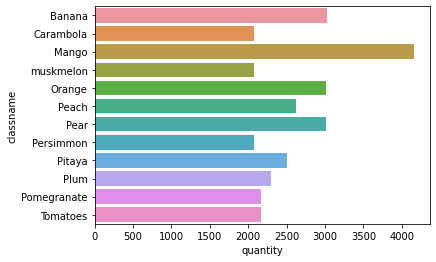

In [7]:
plot_image_folder(DATA_SETS_DIRS)

# Data Spliter & Balancer

In [8]:
if not os.path.isdir(DATA_SETS_SPLIT_OUT_DIRS):
    splitfolders.fixed(DATA_SETS_DIRS, output=DATA_SETS_SPLIT_OUT_DIRS,
                    seed=SEED, fixed=(350, 350), oversample=False, group_prefix=None)

In [9]:
TRAIN_DIRS=DATA_SETS_SPLIT_OUT_DIRS+"/train"
VALIDATE_DIRS=DATA_SETS_SPLIT_OUT_DIRS+"/val"
TEST_DIRS=DATA_SETS_SPLIT_OUT_DIRS+"/test"

      classname  quantity
0        Banana      1372
1     Carambola      1372
2         Mango      1372
3     muskmelon      1372
4        Orange      1372
5         Peach      1372
6          Pear      1372
7     Persimmon      1372
8        Pitaya      1372
9          Plum      1372
10  Pomegranate      1372
11     Tomatoes      1372


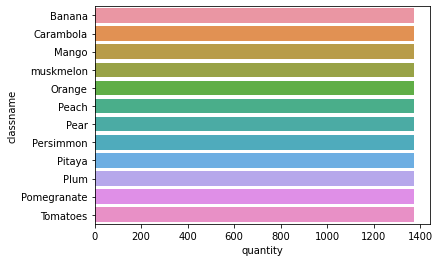

In [10]:
plot_image_folder(TRAIN_DIRS)

## Undersampling

In [11]:
def under_sampling(dirs_path, no_sample=None):

    if no_sample is None:
        min_train_samples = min([len(os.listdir(i))
                                for i in dirs_path.glob("*")])
    prog_bar = tqdm(desc=f"Deleted files", unit=" files")
    for i in dirs_path.glob("*"):
        if no_sample is None:
            quantity_of_remove_image = len(os.listdir(i))-min_train_samples
        else:
            quantity_of_remove_image = no_sample
        remove_images = random.sample(os.listdir(i), quantity_of_remove_image)
        for image in remove_images:
            prog_bar.update()
            f = os.path.join(i, image)
            os.remove(f)
    prog_bar.close()

In [12]:
random.seed(SEED)
under_sampling(pathlib.Path(TRAIN_DIRS))

Deleted files: 0 files [00:00, ? files/s]


# Load train && test data

In [13]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
training_preprocess = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])
validation_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

In [14]:
def load_data_set(dir, transform, batch_size=64):
    data_sets = datasets.ImageFolder(dir, transform=transform)
    return DataLoader(data_sets, batch_size=batch_size)
def decode_label(label, dataloader):
    return dataloader.dataset.classes[label]

In [15]:

train_data_loader = load_data_set(TRAIN_DIRS, training_preprocess, BATCH_SIZE)
validate_data_loader = load_data_set(
    VALIDATE_DIRS,  validation_preprocess, BATCH_SIZE)
test_data_loader= load_data_set(TEST_DIRS, validation_preprocess, BATCH_SIZE)


In [16]:
classes = train_data_loader.dataset.classes


In [17]:
print("train:", len(train_data_loader.dataset.samples))
print("validate:", len(validate_data_loader.dataset.samples))
print("test:", len(test_data_loader.dataset.samples))

train: 16464
validate: 4200
test: 4200


# Feature Extractor

In [18]:
def generate_vector(model, dataloader, device="cpu"):
    model.eval()
    model.to(device)
    results = np.empty((0, 4096))
    labels = np.empty(0)
    for image_batch, label_batch in tqdm(dataloader, unit_scale=BATCH_SIZE, unit="image"):
        predict = model(image_batch.to(device))
        results = np.concatenate((results, predict.detach().cpu()))
        labels = np.concatenate((labels, label_batch))
        del predict
    model.cpu()
    torch.cuda.empty_cache()
    return results, labels


## Alexnet

### setup

In [19]:
alexnet_model = models.alexnet(pretrained=True, progress=True)
alexnet_model.classifier = alexnet_model.classifier[:-1]

### gen vector

In [20]:
x_alex_img_train_sets, y_alex_label_train_sets = generate_vector(
    alexnet_model, train_data_loader, device)



100%|██████████| 16464/16464 [08:04<00:00, 33.98image/s]


In [21]:
x_alex_img_test_sets,  y_alex_label_test_sets = generate_vector(
    alexnet_model, test_data_loader, device)

100%|██████████| 4200/4200 [01:09<00:00, 60.19image/s]


## VGG16

### setup

In [22]:
vgg16_model = models.vgg16(pretrained=True, progress=True)
vgg16_model.classifier = vgg16_model.classifier[:-1]


### gen vector

In [23]:
x_vgg16_img_train_sets, y_vgg16_label_train_sets = generate_vector(
    vgg16_model, train_data_loader, device)

100%|██████████| 16464/16464 [06:51<00:00, 39.97image/s]


In [24]:
x_vgg16_img_test_sets, y_vgg16_label_test_sets = generate_vector(
    vgg16_model, test_data_loader, device)

100%|██████████| 4200/4200 [01:37<00:00, 42.96image/s]


## SIFT

### setup

In [45]:
def sift_generate_vector(model, dataloader, device="cpu"):
    model.eval()
    model.to(device)
    results = np.empty((0, 4096))
    labels = np.empty(0)
    for image_batch, label_batch in tqdm(dataloader, unit_scale=BATCH_SIZE, unit="image"):
        images = [transforms.ToPILImage()(x) for x in image_batch]
        images = [transforms.Grayscale()(x) for x in images]
        images = [transforms.ToTensor()(x) for x in images]
        images = torch.stack(images).to(device)
        predict = model(images)
        results = np.concatenate((results, predict.detach().cpu()))
        labels = np.concatenate((labels, label_batch))
        del predict
    model.cpu()
    torch.cuda.empty_cache()
    return results, labels

In [44]:
sift_model = SIFTDescriptor(patch_size=224,num_ang_bins=64,num_spatial_bins=8)

### gen vector


In [46]:
x_sift_img_train_sets, y_sift_label_train_sets = sift_generate_vector(
    sift_model, train_data_loader, device)


100%|██████████| 16464/16464 [05:14<00:00, 52.37image/s]


In [47]:
x_sift_img_test_sets, y_sift_label_test_sets = sift_generate_vector(
    sift_model, test_data_loader, device)

100%|██████████| 4200/4200 [01:17<00:00, 53.99image/s]


# Train

## ALEXNET-SVM

In [32]:
alexnet_svm_model = svm.SVC(verbose=True)

In [33]:
alexnet_svm_model.fit(x_alex_img_train_sets, y_alex_label_train_sets)

[LibSVM]

SVC(verbose=True)

## VGG16-SVM

In [34]:
vgg16_svm_model = svm.SVC(verbose=True)

In [35]:
vgg16_svm_model.fit(x_vgg16_img_train_sets, y_vgg16_label_train_sets)

[LibSVM]

SVC(verbose=True)

## SIFT-SVM

In [48]:
sift_svm_model = svm.SVC(verbose=True)

In [49]:
sift_svm_model.fit(x_sift_img_train_sets, y_sift_label_train_sets)


[LibSVM]

SVC(verbose=True)

# Analystic

In [38]:
def print_report(model, test_sets, y_true, classes):
    y_pre = model.predict(test_sets)
    print(classification_report(y_true, y_pre,target_names=classes))

## Alexnet - SVM

In [43]:
print_report(alexnet_svm_model,x_alex_img_test_sets,  y_alex_label_test_sets,classes=classes)

              precision    recall  f1-score   support

      Banana       0.99      1.00      1.00       350
   Carambola       0.99      1.00      1.00       350
       Mango       0.99      0.97      0.98       350
      Orange       0.99      1.00      0.99       350
       Peach       1.00      0.99      1.00       350
        Pear       0.97      0.99      0.98       350
   Persimmon       1.00      0.99      1.00       350
      Pitaya       1.00      1.00      1.00       350
        Plum       1.00      1.00      1.00       350
 Pomegranate       0.99      0.99      0.99       350
    Tomatoes       1.00      1.00      1.00       350
   muskmelon       0.98      0.98      0.98       350

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



## VGG16 - SVM

In [41]:
print_report(vgg16_svm_model,x_vgg16_img_test_sets,  y_vgg16_label_test_sets,classes=classes)

              precision    recall  f1-score   support

      Banana       1.00      0.99      0.99       350
   Carambola       0.99      0.99      0.99       350
       Mango       0.97      0.99      0.98       350
      Orange       1.00      0.98      0.99       350
       Peach       0.99      1.00      1.00       350
        Pear       0.98      0.97      0.97       350
   Persimmon       0.99      1.00      0.99       350
      Pitaya       1.00      1.00      1.00       350
        Plum       1.00      1.00      1.00       350
 Pomegranate       0.99      0.99      0.99       350
    Tomatoes       1.00      1.00      1.00       350
   muskmelon       0.99      0.97      0.98       350

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



## SIFT - SVM

In [50]:
print_report(sift_svm_model, x_sift_img_test_sets,  y_sift_label_test_sets,classes=classes)

              precision    recall  f1-score   support

      Banana       0.73      0.60      0.66       350
   Carambola       0.73      0.78      0.75       350
       Mango       0.61      0.45      0.52       350
      Orange       0.69      0.42      0.52       350
       Peach       0.63      0.80      0.70       350
        Pear       0.71      0.45      0.55       350
   Persimmon       0.50      0.86      0.63       350
      Pitaya       0.64      0.62      0.63       350
        Plum       0.77      0.88      0.82       350
 Pomegranate       0.50      0.40      0.44       350
    Tomatoes       0.64      0.80      0.71       350
   muskmelon       0.79      0.76      0.77       350

    accuracy                           0.65      4200
   macro avg       0.66      0.65      0.64      4200
weighted avg       0.66      0.65      0.64      4200

